## Part I: Extracting sample dataset from the Materials Project

In [1]:
# ===========================================================
# INSTALL PACKAGES REQUIRED FOR QUERIES IN MATERIALS PROJECT
# ===========================================================

# Install pymatgen: A library for materials science, used to work with structures and properties.
!pip install pymatgen

# Install mp-api: Official Python client for querying the Materials Project database.
!pip install mp-api

# Install matminer: A library for feature extraction and data mining in materials science.
!pip install matminer

# ===========================================================
# IMPORT LIBRARIES
# ===========================================================

# Import MPRester: used to connect to the Materials Project API and retrieve materials data.
from mp_api.client import MPRester

# Import pandas: for handling tabular data (DataFrames).
import pandas as pd

# Import matplotlib: used for plotting graphs and visualizations.
import matplotlib.pyplot as plt

In [2]:
# ========================
# CONFIGURATION
# ========================

API_KEY = "GpQiLtSH1I5MGrTcWhH6lREZfO4k6kG7"
# 🔑 Your Materials Project API key. For example:
# API_KEY = "sb91iGtpoAFLDhB66Y6ZaOKcIO6BAkXX"
# This is required to authenticate your queries to the Materials Project database.
# Each student/group should use their own API key (you can get one by creating a free MP account).

MAX_ENTRIES = 2000
# 📊 The maximum number of materials to retrieve for our dataset.
# This is useful to keep the dataset size manageable for learning purposes.

GROUP_LETTER = 'D'
# Convert to uppercase and subtract ASCII value of 'A' to get 0-based index (A=0, B=1, ...)
GROUP_NUMBER = ord(GROUP_LETTER.upper()) - ord('A') + 1  # A=1, B=2, ..., Z=26
print(f"Group letter '{GROUP_LETTER}' maps to group number {GROUP_NUMBER}")
# This ensures each group retrieves a different random sample of materials from the Materials Project.

MINGAP = 0.5
# Minimum band gap (in eV) to filter out metallic compounds and those with very narrow gaps.
# Materials with band gaps below this threshold will be excluded from our dataset.


Group letter 'D' maps to group number 4


In [3]:
# ========================
# QUERY MATERIALS PROJECT
# ========================

# Instantiate MagpieData (used later for feature extraction) and get supported elements
magpie = MagpieData()
# ✅ Derive supported element symbols from Magpie property keys
supported_elements = set(magpie.all_elemental_props["Number"].keys())
print("Magpie supports", len(supported_elements), "elements")

# Define exclusion lists
high_Z_list = [Element.from_Z(Z).symbol for Z in range(84, 119)]
# 🚫 Exclude very heavy elements (Z ≥ 84)

halogens_list = ["F", "Cl", "Br", "I"]
# 🚫 Exclude halogens

oxyanion_forming_list = ["P", "C", "S", "N"]
# 🚫 Exclude oxyanion formers

print("Querying MP without long exclusion filters...")

# Query the Materials Project database for oxide candidates
with MPRester(API_KEY) as mpr:
    summary_docs = mpr.materials.summary.search(
        elements=["O"],                       # ✅ Must contain oxygen
        num_elements=(2, 4),                  # ✅ Binary, ternary, or quaternary oxides
        fields=["material_id", "formula_pretty", "elements", "band_gap", "energy_above_hull"],
        num_chunks=None
    )

# Convert query results (documents) to a Pandas DataFrame
df_summary = pd.DataFrame([
    {
        "material_id": d.material_id,
        "formula_pretty": d.formula_pretty,
        "elements": d.elements,
        "band_gap": d.band_gap,
        "energy_above_hull": d.energy_above_hull,
    }
    for d in summary_docs
])
print(f"Retrieved {len(df_summary)} oxide candidates from summary.")

# 🔑 Normalize elements to strings (symbols), not Element objects
df_summary["elements"] = df_summary["elements"].apply(
    lambda es: [getattr(e, "symbol", e) for e in es]
)

# Local filtering: Remove materials with unwanted elements
def is_valid_oxide(elements):
    """
    Filters out materials that:
    - Contain very heavy (high-Z) elements
    - Contain halogens
    - Contain oxyanion-forming elements (P, C, S, N)
    - Include any element unsupported by Magpie
    - Always allow oxygen
    """
    return all(
        (el not in high_Z_list) and
        (el not in halogens_list) and
        (el not in oxyanion_forming_list) and
        (el in supported_elements)
        for el in elements if el != "O"
    )

# Apply filtering function to remove unwanted compounds
df_summary = df_summary[df_summary["elements"].apply(is_valid_oxide)].reset_index(drop=True)
print(f"After local filtering: {len(df_summary)} oxides remain (Magpie-compatible and excluding unwanted elements).")

NameError: name 'MagpieData' is not defined

In [ ]:
# ========================
# FURTHER FILTERING
# ========================

def chunk_list(lst, size):
    """Yield chunks of length `size` (MP API-friendly batching)."""
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

all_calc_data = []

with MPRester(API_KEY) as mpr:
    for chunk in chunk_list(df_summary["material_id"].tolist(), 1000):
        calc_docs = mpr.materials.search(
            material_ids=chunk,
            fields=["material_id", "calc_types"],
            num_chunks=1
        )
        all_calc_data.extend(calc_docs)

df_calc = pd.DataFrame([
    {"material_id": d.material_id, "calc_types": getattr(d, "calc_types", None)}
    for d in all_calc_data
])
print(f"Retrieved calc_types for {len(df_calc)} entries.")

# --- EXTRACT THEORY LEVEL AND HUBBARD FLAG ---
def extract_theory(calc_types):
    def _to_label(x):
        if x is None:
            return None
        if isinstance(x, str):
            return x
        for attr in ("value", "label", "name"):
            if hasattr(x, attr):
                return str(getattr(x, attr))
        return str(x)

    if isinstance(calc_types, dict):
        labels = [_to_label(v) for v in calc_types.values() if v is not None]

        if any("GGA+U" in lbl for lbl in labels if lbl):
            return pd.Series({"theory_level": "GGA+U", "is_hubbard": True})
        if any(lbl and (lbl == "GGA" or lbl.startswith("GGA")) for lbl in labels):
            return pd.Series({"theory_level": "GGA", "is_hubbard": False})
        if any("r2SCAN" in lbl for lbl in labels if lbl):
            return pd.Series({"theory_level": "r2SCAN", "is_hubbard": False})
        if any("SCAN" in lbl for lbl in labels if lbl):
            return pd.Series({"theory_level": "SCAN", "is_hubbard": False})

        return pd.Series({
            "theory_level": (labels[0] if labels else None),
            "is_hubbard": any("+U" in lbl for lbl in labels if lbl)
        })

    return pd.Series({"theory_level": None, "is_hubbard": False})

df_calc_info = pd.concat(
    [df_calc["material_id"], df_calc["calc_types"].apply(extract_theory)],
    axis=1
)

df_summary["material_id"] = df_summary["material_id"].astype(str)
df_calc_info["material_id"] = df_calc_info["material_id"].astype(str)
df = df_summary.merge(df_calc_info, on="material_id", how="inner")
print(f"Step 1 — merged summary + calc_types: {len(df)} entries")
print("  Detected theory levels:", df["theory_level"].dropna().unique())

# --- FILTERING ---
before = len(df)
df = df.dropna(subset=["band_gap", "energy_above_hull", "theory_level"])
print(f"Step 2 — drop missing values: {before} → {len(df)}")

before = len(df)
df = df[df["band_gap"] > MINGAP]
print(f"Step 3 — remove metallics (band_gap ≤ {MINGAP} eV): {before} → {len(df)}")

before = len(df)
df = df[df["theory_level"].isin(["GGA", "GGA+U"])]
print(f"Step 4 — keep only GGA / GGA+U: {before} → {len(df)}")

# --- SELECT LOWEST-ENERGY POLYMORPH ---
before = len(df)
df_sorted = df.sort_values(
    by=["formula_pretty", "is_hubbard", "energy_above_hull"],
    ascending=[True, False, True]
)
df_unique = df_sorted.groupby("formula_pretty", as_index=False).first()
print(f"Step 5 — select lowest-energy polymorph (GGA+U preferred): {before} → {len(df_unique)}")

# Final dataset
print(f"✅ Final dataset size: {len(df_unique)} unique compositions")

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/664 [00:00<?, ?it/s]

Retrieved calc_types for 40664 entries.
Step 1 — merged summary + calc_types: 40664 entries
  Detected theory levels: ['GGA' 'GGA+U' 'r2SCAN']
Step 2 — drop missing values: 40664 → 40664
Step 3 — remove metallics (band_gap ≤ 0.5 eV): 40664 → 21223
Step 4 — keep only GGA / GGA+U: 21223 → 21135
Step 5 — select lowest-energy polymorph (GGA+U preferred): 21135 → 12301
✅ Final dataset size: 12301 unique compositions
Step 1 — merged summary + calc_types: 40664 entries
  Detected theory levels: ['GGA' 'GGA+U' 'r2SCAN']
Step 2 — drop missing values: 40664 → 40664
Step 3 — remove metallics (band_gap ≤ 0.5 eV): 40664 → 21223
Step 4 — keep only GGA / GGA+U: 21223 → 21135
Step 5 — select lowest-energy polymorph (GGA+U preferred): 21135 → 12301
✅ Final dataset size: 12301 unique compositions


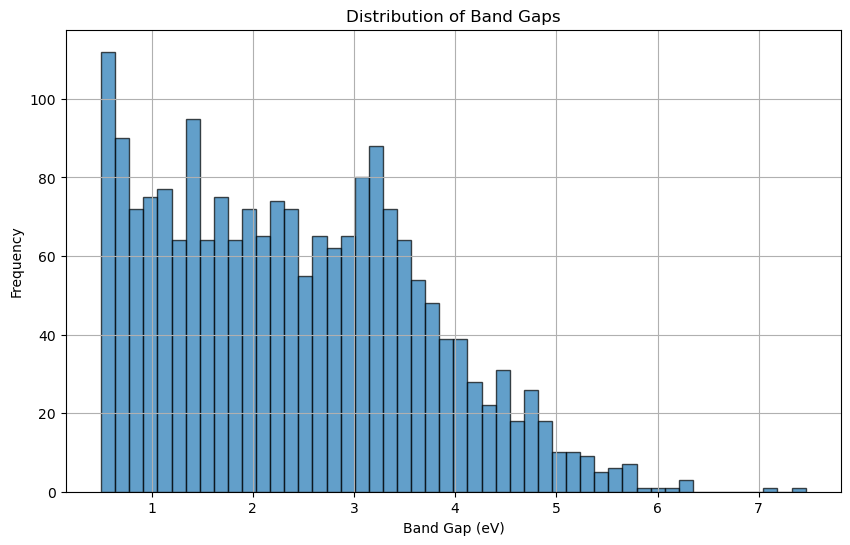

In [ ]:
# ========================
# FINAL SAMPLING AND VISUALISATION
# ========================

# Randomly sample MAX_ENTRIES oxides for this group (different groups can sample differently)
df_sample = df_unique.sample(n=MAX_ENTRIES, random_state=GROUP_NUMBER)


# Create a histogram to visualize the distribution of band gaps in the sampled oxides dataset.
plt.figure(figsize=(10, 6))                  # Set figure size (width=10, height=6 inches)
plt.hist(df_sample['band_gap'],              # Data to plot: band gap column
         bins=50,                            # Number of bins in the histogram
         edgecolor='k',                      # Black edges around the bars for clarity
         alpha=0.7)                          # Transparency (0=transparent, 1=solid)

# Label the axes and add a title
plt.xlabel('Band Gap (eV)')                  # X-axis label: Band gap in electron volts
plt.ylabel('Frequency')                      # Y-axis label: Count of materials
plt.title('Distribution of Band Gaps')       # Plot title

# Add a grid to make it easier to read values from the plot
plt.grid(True)

# Display the plot
plt.show()


# Part II. Extracting composition-based features with Matminer

In [ ]:
# ---------------
# Configuration
# ---------------

# Suppress irrelevant warnings from matminer (for cleaner output in notebooks)
import warnings
warnings.filterwarnings("ignore", message="PymatgenData")
warnings.filterwarnings("ignore", message="MagpieData")
warnings.filterwarnings("ignore", message="IonProperty")
warnings.filterwarnings("ignore", message="ValenceOrbital")
warnings.filterwarnings("ignore", message="DemlData")

# Import the necessary featurizers and utilities from matminer
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty, BandCenter
from matminer.featurizers.base import MultipleFeaturizer
from matminer.utils.data import MagpieData
from pymatgen.core import Composition
from sklearn.impute import SimpleImputer
import pandas as pd

# Print how many oxides we are featurizing
print(f"Loaded {len(df_sample)} oxides for feature extraction.")


# Convert chemical formulas to pymatgen Composition objects (needed by matminer featurizers)
df_sample["composition"] = df_sample["formula_pretty"].apply(Composition)


# Define elemental properties from the Magpie dataset to use as features
# - These include basic periodic properties and valence information.
element_props = ElementProperty.from_preset("magpie", impute_nan=True)
element_props.features = [
    "MendeleevNumber", "Electronegativity", "CovalentRadius",
    "NsValence", "NpValence", "NdValence", "NfValence"
]
element_props.stats = ["mean", "range", "avg_dev"]  # Aggregate statistics for each property

# ------------------------------------------------
# Build a featurizer pipeline:
# - ElementProperty: statistics from Magpie properties
# - Stoichiometry: size/complexity descriptors (we will drop n-norms later)
# - ValenceOrbital: fraction of s/p/d/f electrons
# - IonProperty: ionic radii and ionicity
# - BandCenter: estimated valence band center (composition-based)
# ------------------------------------------------
featurizer = MultipleFeaturizer([
    element_props,
    Stoichiometry(),
    ValenceOrbital(),
    IonProperty(),
    BandCenter()
])

print("[INFO] Extracting composition-only features (no n-norms)...")

# Apply the featurizer to the dataset
df_feats = featurizer.featurize_dataframe(df_sample, col_id="composition", ignore_errors=True)
print(f"[DEBUG] Raw feature shape: {df_feats.shape}")

# ------------------------------------------------
# Keep only relevant columns: IDs, target (band_gap), and computed features.
# ------------------------------------------------
id_cols = ["material_id", "formula_pretty"]
target_cols = ["band_gap"]
cols_to_exclude = ["composition", "elements", "is_hubbard", "theory_level", "energy_above_hull"]
cols_to_keep = id_cols + target_cols + [c for c in df_feats.columns if c not in cols_to_exclude]
df_final = df_feats[cols_to_keep]

# Remove any duplicate column names
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# ------------------------------------------------
# Remove n-norm features explicitly (not useful for our analysis here)
# ------------------------------------------------
n_norm_cols = [col for col in df_final.columns if "-norm" in col]
if n_norm_cols:
    print(f"[WARN] Dropping n-norm features: {n_norm_cols}")
    df_final = df_final.drop(columns=n_norm_cols)

# ------------------------------------------------
# Drop any columns that are entirely NaN (contain no useful information)
# ------------------------------------------------
nan_cols = [col for col in df_final.columns if df_final[col].isna().all() and col not in id_cols]
if nan_cols:
    print(f"[WARN] Dropping {len(nan_cols)} fully-NaN columns: {nan_cols}")
    df_final = df_final.drop(columns=nan_cols)

# ------------------------------------------------
# Split the dataframe into:
# - IDs (material_id, formula)
# - Target (band_gap)
# - Features (all numeric descriptors for ML)
# ------------------------------------------------
ids = df_final[id_cols]
target = df_final[target_cols]
features = df_final.drop(columns=id_cols + ["band_gap"])

# ------------------------------------------------
# Remove any non-numeric feature columns (in case any slipped through)
# ------------------------------------------------
non_numeric = features.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric:
    print(f"[WARN] Dropping {len(non_numeric)} non-numeric columns: {non_numeric}")
    features = features.drop(columns=non_numeric)

# ------------------------------------------------
# Impute missing values in features using the column mean
# ------------------------------------------------
nan_counts = features.isna().sum()
cols_with_nans = nan_counts[nan_counts > 0]

if not cols_with_nans.empty:
    print(f"[INFO] Imputing missing values in {len(cols_with_nans)} columns:")
    for col, count in cols_with_nans.items():
        print(f"    - {col}: {count} missing values (imputed with column mean)")
else:
    print("[INFO] No missing values found — no imputation needed.")

imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# ------------------------------------------------
# Combine IDs + target + imputed features into the final dataframe
# ------------------------------------------------
df_final_imputed = pd.concat([ids.reset_index(drop=True),
                               target.reset_index(drop=True),
                               X_imputed.reset_index(drop=True)], axis=1)

print(f"✅ Final dataset: {df_final_imputed.shape[0]} rows, {df_final_imputed.shape[1]-len(id_cols)-1} features + target.")
print(f"Final columns: {df_final_imputed.columns.tolist()}")

datafilename = f"features_g{GROUP_LETTER.upper()}.csv"
df_final_imputed.to_csv(datafilename, index=False)


Loaded 2000 oxides for feature extraction.
[INFO] Extracting composition-only features (no n-norms)...


c:\Users\felix\anaconda3\Lib\site-packages\matminer\featurizers\composition\element.py:216: UserWarning: BandCenter(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


MultipleFeaturizer:   0%|          | 0/2000 [00:00<?, ?it/s]

[DEBUG] Raw feature shape: (2000, 47)
[WARN] Dropping n-norm features: ['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm']
[WARN] Dropping 1 non-numeric columns: ['compound possible']
[INFO] No missing values found — no imputation needed.
✅ Final dataset: 2000 rows, 32 features + target.
Final columns: ['material_id', 'formula_pretty', 'band_gap', 'MagpieData mean MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mean Electronegativity', 'MagpieData range Electronegativity', 'MagpieData avg_dev Electronegativity', 'MagpieData mean CovalentRadius', 'MagpieData range CovalentRadius', 'MagpieData avg_dev CovalentRadius', 'MagpieData mean NsValence', 'MagpieData range NsValence', 'MagpieData avg_dev NsValence', 'MagpieData mean NpValence', 'MagpieData range NpValence', 'MagpieData avg_dev NpValence', 'MagpieData mean NdValence', 'MagpieData range NdValence', 'MagpieData avg_dev NdValence', 'MagpieData mean NfValence', 'MagpieD